<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/02_neural_network_classification_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Neural Networks in TensorFlow Tutorial


A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo is of food, a person or a dog. This is called **multi-class classification** since there are more than two options. i.e. Each instance (sample) is assigned to one and only one label out of a set of mutually exclusive labels. food, a person or a dog.
* Each instance can be assigned to multiple labels simultaneously.. This is called **multi-label classification**. E.g. Movie genre categorization - Labels: Action, Comedy, Drama, Fantasy, Horror, Romance



## Contents

- Architecture of a classification model
- Input shapes and output shapes
  - `x`: features/varibles/Independant features (inputs)
  - `y`: labels/target/depandant variable (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Create a model
  - Compile a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fit a model (find patterns in our data)
- The power of non-linearity
- Evaluate the model
  - Visualize the model
  - Look at the training curves
  - Compare predictions to actuals/ground truth
  

## How to use this notebook

You can read through the descriptions and simply run the code (it should run without errors), but there's a better option.

However, better option is for an hands on experience is to create a new notebook, and rewrite each code line by yourself. Investigate it, see if it fails and throws error. Learn why it fails.

# Architecture of a classification neural network 



| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |


In [1]:
import tensorflow as tf
print(tf.__version__)

2023-11-13 22:18:05.413382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


# Creating data to view and fit


Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.



In [4]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
x, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [6]:
# Check out the features
x

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [7]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [8]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":x[:, 0], "X1":x[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


What kind of labels are we dealing with?

In [9]:
# Check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

Alright, looks like we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

Let's take our visualization a step further and plot our data.

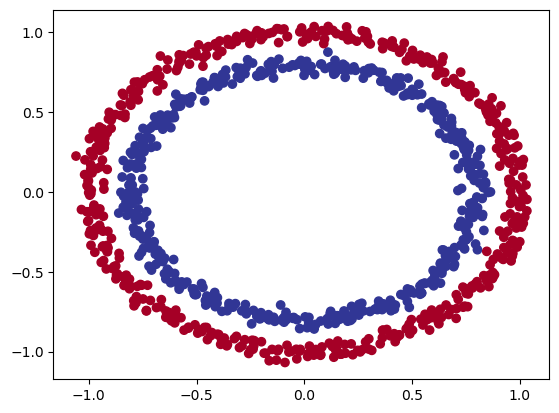

In [11]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> **Practice:** Before pushing forward, let's spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). 
Try adjusting the different hyperparameters you see and click play to see a neural network train. You'll find the data very similar to what we've just created.

# Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `x` and get our model to predict `y`.

So let's check out the shapes of `x` and `y`.

In [13]:
# Check the shapes of our features and labels
x.shape, y.shape

((1000, 2), (1000,))

Hmm, where do these numbers come from?

In [14]:
# Check how many samples we have
len(x), len(y)

(1000, 1000)

So we've got as many `x` values as we do `y` values, that makes sense.

Let's check out one example of each.

In [16]:
# View the first example of features and labels
x[0], y[0]

(array([0.75424625, 0.23148074]), 1)

Alright, so we've got two `x` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.

> **Note:** `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension.

# Steps in Modelling

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential))
2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `x` relates to `y`). 


In [18]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(x, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 2ms/step - loss: 5.1032 - accuracy: 0.4570
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 4.3927 - accuracy: 0.4600
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 3.3981 - accuracy: 0.4710
Epoch 4/5
32/32 [==============================] - 0s 6ms/step - loss: 0.7720 - accuracy: 0.4960
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.4960


Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [22]:
# Train our model for longer (more chances to look at the data)
model_1.fit(x, y, epochs=100, verbose=0) # set verbose=0 to remove training updates
model_1.evaluate(x, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5000


[0.693244993686676, 0.5]

Even after 100 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [23]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1) 
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(x, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

In [24]:
# Evaluate the model
model_2.evaluate(x, y)

32/32 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5000


[0.6941279172897339, 0.5]

Still not even as good as guessing (~50% accuracy)

Let's remind ourselves of a couple more ways we can use to improve our models.

# Improving a model


To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose optimization function or perhaps change the **learning rate** of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more **epochs** (leave it training for longer) or on more data (give the model more examples to learn from).

We can try adding more neurons, an extra layer and the Adam optimizer?


In [25]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(x, y, epochs=100, verbose=0) # fit for 100 passes of the data

In [26]:
# Evaluate the model
model_3.evaluate(x, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5110


[0.6949295401573181, 0.5109999775886536]

The model is still bad. Let's visualize the model.

In [35]:
import numpy as np

def plot_decision_boundary(model, x, y):
  """
  Plots the decision boundary created by a model predicting on x.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
  y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create x values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


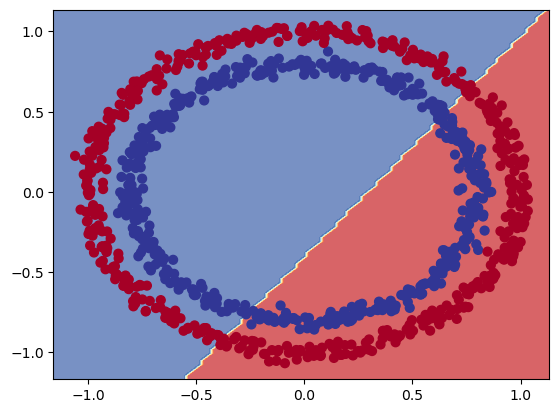

In [36]:
# Check out the predictions our model is making 
plot_decision_boundary(model_3, x, y)

See the problem? Our model is trying to draw a straight line through the data.

What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

# Evaluating and improving our classification model

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

In [37]:
# How many examples are in the whole dataset?
len(x)

1000

In [38]:
# Split data into train and test sets
x_train, y_train = x[:800], y[:800] # 80% of the data for the training set
x_test, y_test = x[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
x_train.shape, x_test.shape # 800 examples in the training set, 200 examples in the test set 

((800, 2), (200, 2))

Great, now we've got training and test sets, let's model the training data and evaluate what our model has learned on the test set.

In [62]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 4ms/step - loss: 0.6937 - accuracy: 0.4762
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4888
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5013
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4988
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5013
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4988
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.4988
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5063
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5138
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5150
Epoch 11/

25/25 [==============================] - 0s 3ms/step - loss: 0.4714 - accuracy: 0.8737
Epoch 84/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4611 - accuracy: 0.8750
Epoch 85/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4526 - accuracy: 0.8825
Epoch 86/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4471 - accuracy: 0.8725
Epoch 87/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.8988
Epoch 88/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4378 - accuracy: 0.8850
Epoch 89/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8913
Epoch 90/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.8925
Epoch 91/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4229 - accuracy: 0.9025
Epoch 92/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.9075
Epoch 93/100


In [63]:
# Evaluate our model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 4ms/step - loss: 0.3714 - accuracy: 0.9450
Model loss on the test set: 0.37142184376716614
Model accuracy on the test set: 94.50%


Excellent.

* **The `activation` parameter** - We used strings (`"relu"` & `"sigmoid"`) instead of using library paths (`tf.keras.activations.relu`), in TensorFlow, they both offer the same functionality.
* **The `learning_rate` (also `lr`) parameter** - We increased the **learning rate** parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).
  * You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a *too high* learning rate, where a model tries to learn too fast and doesn't learn anything. We'll see a trick to find the ideal learning rate soon.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.


313/313 [==============================] - 1s 1ms/step
doing binary classifcation...
313/313 [==============================] - 1s 3ms/step
doing binary classifcation...


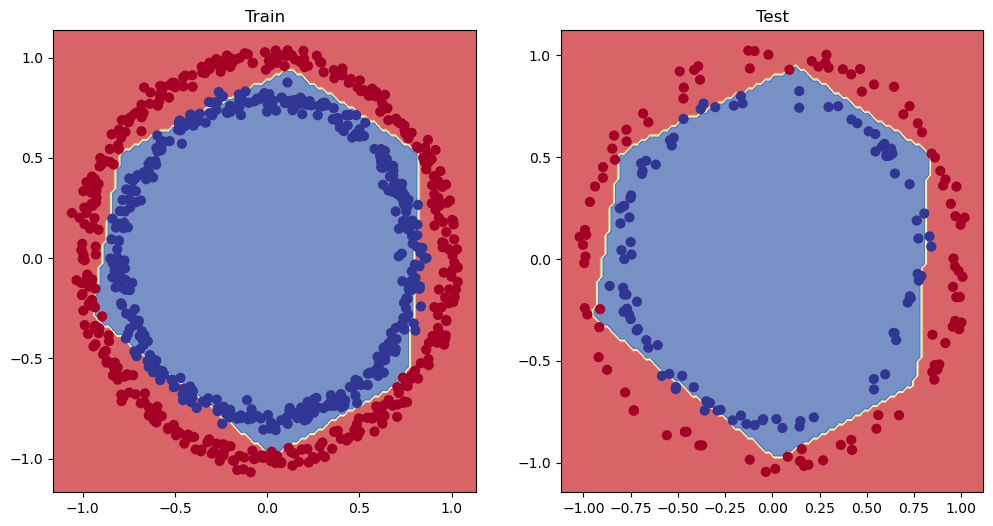

In [67]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x=x_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x=x_test, y=y_test)
plt.show()

Check that out! With a few tweaks, the model is now predicting the blue and red circles almost perfectly.

## Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.


In [68]:
# You can access the information in the history variable using the .history attribute
pd.DataFrame(history.history)

,loss,accuracy
0,0.693685,0.47625
1,0.693207,0.48875
2,0.692828,0.50125
3,0.692418,0.49875
4,0.692057,0.50125
...,...,...
95,0.400616,0.91250
96,0.397620,0.91750
97,0.392570,0.92500
98,0.388576,0.92250


Inspecting the outputs, we can see the loss values going down and the accuracy going up. 

How's it look (visualize, visualize, visualize)?

Text(0.5, 1.0, 'Model_8 training curves')

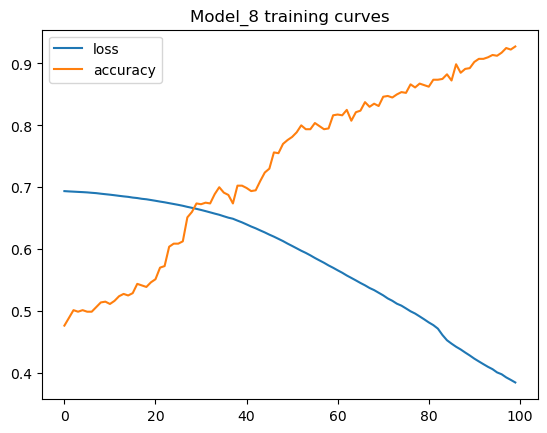

In [69]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

Beautiful. This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

> **Note:** The loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).

## Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model` you saw we changed the Adam optimizer's learning rate from the default of `0.001` to `0.01`.

To find the optimal learning rate we're going to use the following:

* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.


> **Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [71]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy", # we can use strings here too
              optimizer="Adam", # same as tf.keras.optimizers.Adam() with default settings
              metrics=["accuracy"]) 

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Fit the model (passing the lr_scheduler callback)
history = model_2.fit(x_train, 
                      y_train, 
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
25/25 [==============================] - 1s 2ms/step - loss: 0.6927 - accuracy: 0.4988 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4787 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.4863 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4913 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4950 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4925 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4925 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4925 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss:

Epoch 73/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.9463 - lr: 0.3981
Epoch 74/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1529 - accuracy: 0.9300 - lr: 0.4467
Epoch 75/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.8963 - lr: 0.5012
Epoch 76/100
25/25 [==============================] - 0s 4ms/step - loss: 0.2222 - accuracy: 0.9162 - lr: 0.5623
Epoch 77/100
25/25 [==============================] - 0s 4ms/step - loss: 0.1629 - accuracy: 0.9300 - lr: 0.6310
Epoch 78/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5144 - accuracy: 0.8275 - lr: 0.7079
Epoch 79/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6300 - lr: 0.7943
Epoch 80/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5626 - accuracy: 0.6762 - lr: 0.8913
Epoch 81/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5664 - accuracy: 0.6

Now our model has finished training, let's have a look at the training history.

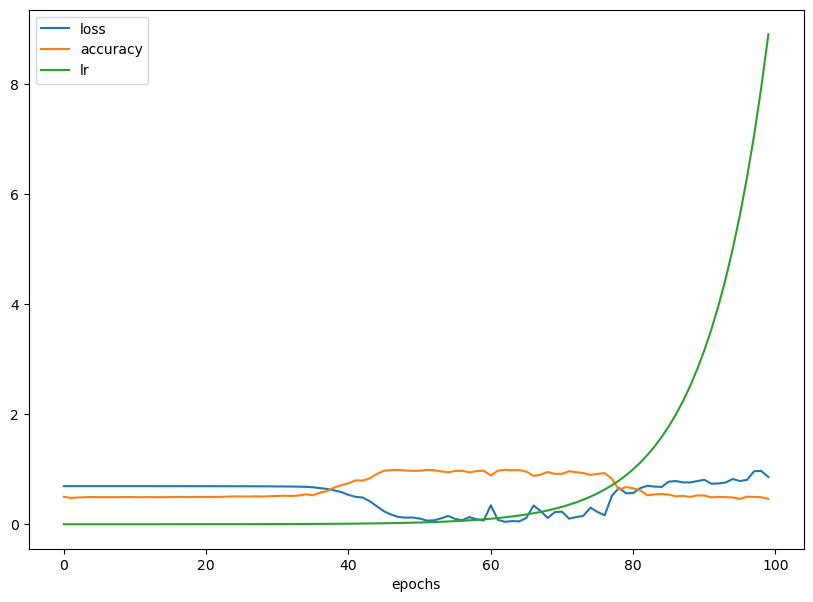

In [72]:
# Checkout the history
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

As you you see the learning rate exponentially increases as the number of epochs increases.

And you can see the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate.

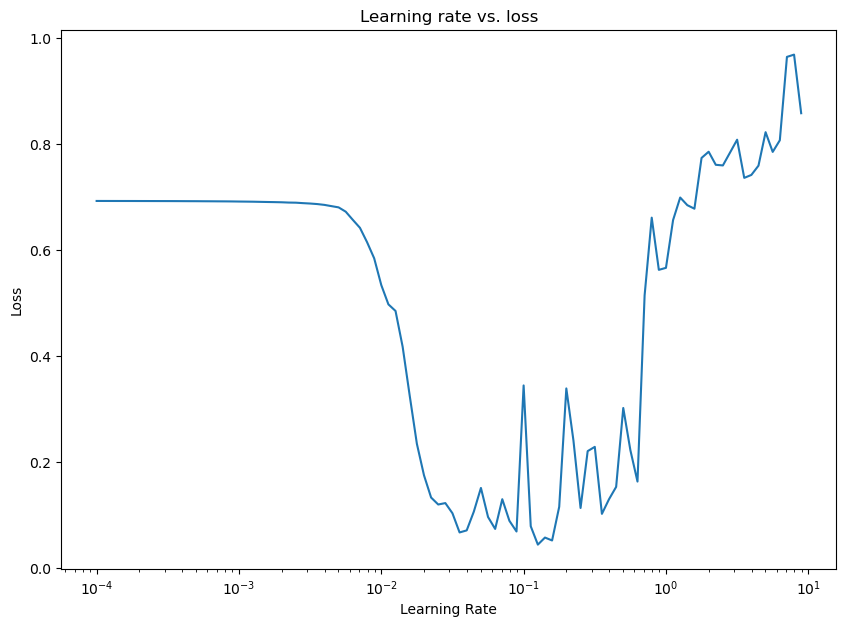

In [73]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [74]:
# Example of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 1e-4

(1, 0.1, 0.01, 0.001, 0.0001)

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [82]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model with the ideal learning rate
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.02), # to adjust the learning rate, you need to use tf.keras.optimizers.Adam (not "adam")
                metrics=["accuracy"])

# Fit the model for 20 epochs (5 less than before)
history = model_3.fit(x_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 2ms/step - loss: 0.6959 - accuracy: 0.4863
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6950 - accuracy: 0.4863
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4863
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4850
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.4963
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.4888
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.4938
Epoch 8/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5362
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.5487
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5612
Epoch 11/

25/25 [==============================] - 0s 3ms/step - loss: 0.5817 - accuracy: 0.7575
Epoch 84/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5776 - accuracy: 0.7613
Epoch 85/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7700
Epoch 86/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5696 - accuracy: 0.7650
Epoch 87/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5641 - accuracy: 0.7837
Epoch 88/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5557 - accuracy: 0.7725
Epoch 89/100
25/25 [==============================] - 0s 4ms/step - loss: 0.5477 - accuracy: 0.7800
Epoch 90/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5394 - accuracy: 0.7800
Epoch 91/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.7975
Epoch 92/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5211 - accuracy: 0.8112
Epoch 93/100


Nice! With a little higher learning rate (`0.02` instead of `0.01`) we reach a higher accuracy than `model_8` in less epochs (`20` instead of `25`).

> 🛠 **Practice:** Now you've seen an example of what can happen when you change the learning rate, try changing the learning rate value in the [TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.03154&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&problem_hide=true) and see what happens. What happens if you increase it? What happens if you decrease it?



In [83]:
# Evaluate model on the test dataset
model_3.evaluate(x_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4740 - accuracy: 0.9150


[0.4739711880683899, 0.9150000214576721]



Let's see how the predictions look.

313/313 [==============================] - 1s 1ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


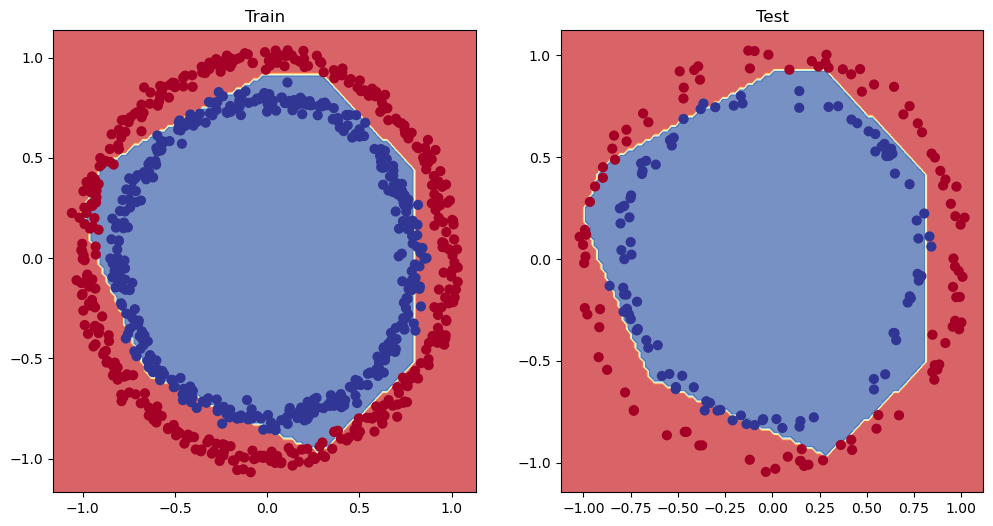

In [85]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x=x_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x=x_test, y=y_test)
plt.show()

## More classification evaluation methods

There are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |



In [87]:
# Check the accuracy of our model
loss, accuracy = model_3.evaluate(x_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.4740 - accuracy: 0.9150
Model loss on test set: 0.4739711880683899
Model accuracy on test set: 91.50%


In [89]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model_3.predict(x_test)

# Create confusion matrix
confusion_matrix(y_test, y_pred)

7/7 [==============================] - 0s 3ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

Ahh, it seems our predictions aren't in the format they need to be.

Let's check them out.

In [91]:
# View the first 10 predictions
y_pred[:10]

array([[0.6409259 ],
       [0.6914606 ],
       [0.6574368 ],
       [0.5870251 ],
       [0.38290268],
       [0.47530663],
       [0.64100987],
       [0.15824558],
       [0.5613    ],
       [0.37820944]], dtype=float32)

What about our test labels?

In [92]:
# View the first 10 test labels
y_test[:10]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [93]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_pred)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

Wonderful! Now we can use the `confusion_matrix` function.

In [95]:
# Create a confusion matrix
confusion_matrix(y_test, tf.round(y_pred))

array([[96,  5],
       [12, 87]])

Alright, we can see the highest numbers are down the diagonal (from top left to bottom right) so this a good sign, but the rest of the matrix doesn't really tell us much.


That looks much better. It seems our model has made almost perfect predictions on the test set except for two false positives (top right corner).

# How a model learns (in brief)

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the `fit()` function).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

In other words, data and labels pass through a model (**forward pass**) and it attempts to learn the relationship between the data and labels. 

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (**backward pass**) and tweaking its weights matrices and bias values to better represent the data.


## Role of Activation Functions

In [98]:
# Create a toy tensor (similar to the data we pass into our model)
A = tf.cast(tf.range(-10, 10), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

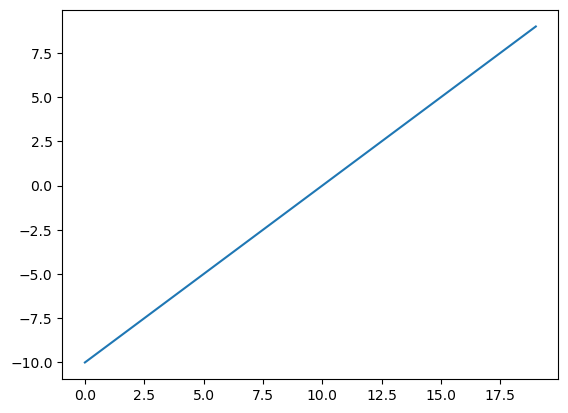

In [99]:
# Visualize our toy tensor
plt.plot(A);

A straight (linear) line!

1. Try [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to the data. You can find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

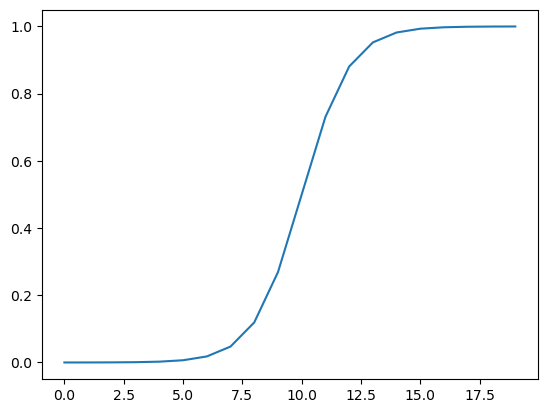

In [100]:
# Plot sigmoid modified tensor
plt.plot(tf.keras.activations.sigmoid(A));

RESULT - A non-linear Line.

2. Try the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.)

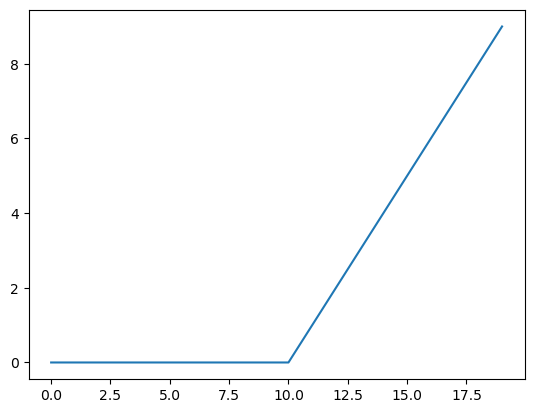

In [101]:
# Plot ReLU-modified tensor
plt.plot(tf.keras.activations.relu(A));

Another non-straight line.

ReLU turns all negatives to 0 and positive numbers stay the same.

3. Try the [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)? 

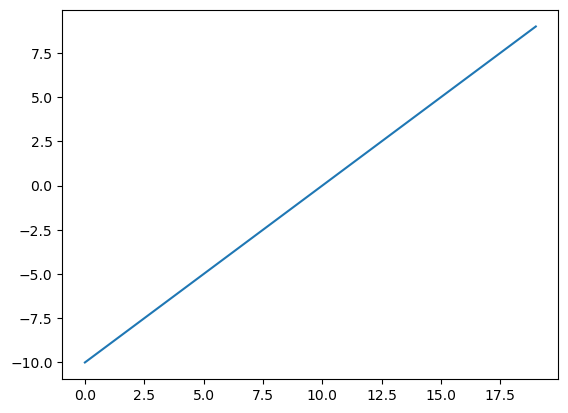

In [107]:
# Linear - https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear (returns input non-modified...)
plt.plot(tf.keras.activations.linear(A));

Result: The inputs are unmodified.

The model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Whereas, with non-linear functions, the data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.


> **Resource:** For more on activation functions, check out [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#)

# Exercise

1. Play with neural networks in the [TensorFlow Playground](https://playground.tensorflow.org/) for 10-minutes. Especially try different values of the learning, what happens when you decrease it? What happens when you increase it?


# Extra curriculum 📖
* Watch 3Blue1Brown's neural networks video 2: [*Gradient descent, how neural networks learn*](https://www.youtube.com/watch?v=IHZwWFHWa-w). After you're done, write 100 words about what you've learned.
  * If you haven't already, watch video 1: [*But what is a Neural Network?*](https://youtu.be/aircAruvnKk). Note the activation function they talk about at the end.
* Watch [MIT's introduction to deep learning lecture 1](https://youtu.be/njKP3FqW3Sk) (if you haven't already) to get an idea of the concepts behind using linear and non-linear functions.
* Spend 1-hour reading [Michael Nielsen's Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/index.html).
* Read the [ML-Glossary documentation on activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html). Which one is your favourite?
  * After you've read the ML-Glossary, see which activation functions are available in TensorFlow by searching "tensorflow activation functions".